# Подготовка данных и анализ

In [275]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%cd ..
# Загрузка данных
train_df = pd.read_csv('/content/train.csv')
key_df = pd.read_csv('/content/key.csv')
weather_df = pd.read_csv('/content/weather_by_city.csv')
store_coords_df = pd.read_csv('/content/store_city_coordinates.csv')

# ШАГ 1: Отбор 20 магазинов и создание уникального ID
#уменьшение объёма данных для прототипа и ускорения обработки, c сохраннением географической и товарной репрезентативности.
selected_stores = train_df['store_nbr'].drop_duplicates().sample(n=20, random_state=42)
train_subset = train_df[train_df['store_nbr'].isin(selected_stores)].copy()
train_subset['unique_id'] = train_subset['store_nbr'].astype(str) + "_" + train_subset['item_nbr'].astype(str)

# ШАГ 2: Связь магазинов с городами
store_station_city_df = pd.merge(key_df, store_coords_df, on='store_nbr', how='left')

# Приведение городов к нижнему регистру и удаление пробелов
store_station_city_df['city'] = store_station_city_df['city'].str.lower().str.strip()
weather_df['city'] = weather_df['city'].str.lower().str.strip()

# ШАГ 3: Объединение по дате и городу
#это основная цель проекта — понять, как погода влияет на продажи. Использован ключ (дата + город).
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['date'] = weather_df['date'] - pd.DateOffset(years=11)
weather_df['date'] = weather_df['date'].dt.strftime('%Y-%m-%d')

# Объединение train_subset с городами
train_merged = pd.merge(train_subset, store_station_city_df[['store_nbr', 'city']], on='store_nbr', how='left')

# Объединение train_merged с погодой
train_merged_weather = pd.merge(train_merged, weather_df, on=['date', 'city'], how='left')

# Сохранение результата
train_merged_weather.to_csv('train_with_weather.csv', index=False)


## Обработка выбросов и заполнение пропусков

In [276]:
df = pd.read_csv('train_with_weather.csv')

# Типизация
df['date'] = pd.to_datetime(df['date'])
df['store_nbr'] = df['store_nbr'].astype(int)
df['item_nbr'] = df['item_nbr'].astype(int)
df['city'] = df['city'].astype(str).str.lower().str.strip()

# ===  ПРОПУСКИ ===
#восполняем пропуски усредняя по городу. Это сохраняет климатические особенности регионов и не искажает общую структуру данных.
df['avg_temp_c'] = df.groupby('city')['avg_temp_c'].transform(lambda x: x.fillna(x.mean()))
df['avg_temp_c'].fillna(df['avg_temp_c'].mean(), inplace=True)

df['precipitation_mm'] = df.groupby('city')['precipitation_mm'].transform(lambda x: x.fillna(x.mean()))
df['precipitation_mm'].fillna(df['precipitation_mm'].mean(), inplace=True)

# === ЛОГАРИФМИРОВАНИЕ ПРОДАЖ ===
#уменьшает влияние выбросов, нормализует распределение продаж. Это улучшает стабильность и интерпретируемость регрессионных моделей.
df['log_units'] = np.log1p(df['units'])

# ===  КОДИРОВАНИЕ КАТЕГОРИЙ ===
le_city = LabelEncoder()
df['city_code'] = le_city.fit_transform(df['city'])

le_uid = LabelEncoder()
df['unique_id_code'] = le_uid.fit_transform(df['unique_id'])
# === Выбросы через Z-score ===
#заменяем отклоняющиеся значения медианами по паре магазин + товар. Это сохраняет полноту выборки без искажения метрик.
numeric_cols = ['units', 'avg_temp_c', 'precipitation_mm', 'log_units']
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df['outlier'] = (z_scores > 3).any(axis=1)



<ipython-input-276-5de2ccc2e289>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_temp_c'].fillna(df['avg_temp_c'].mean(), inplace=True)
<ipython-input-276-5de2ccc2e289>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Общее количество выбросов: 49343
Процент выбросов: 2.40%


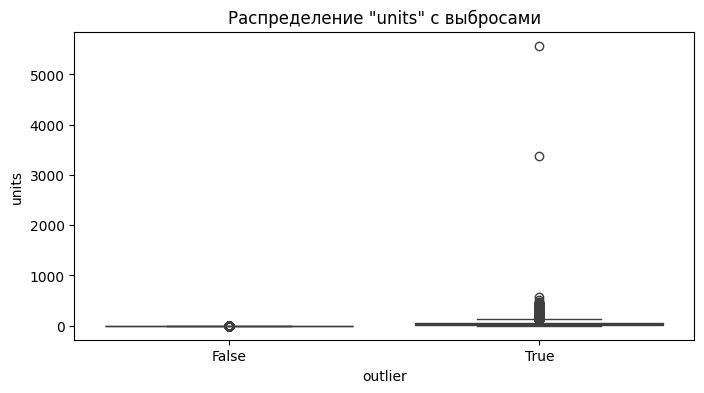

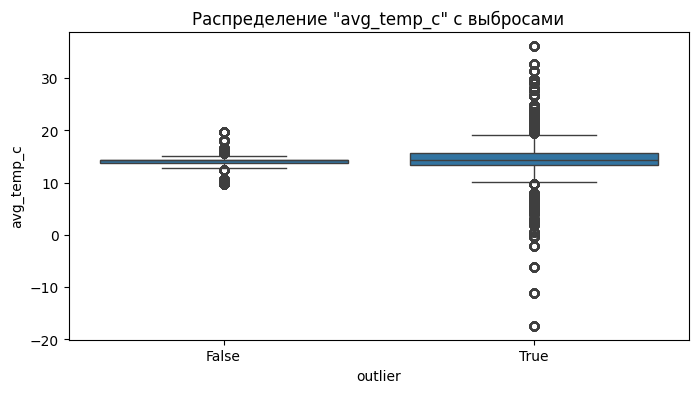

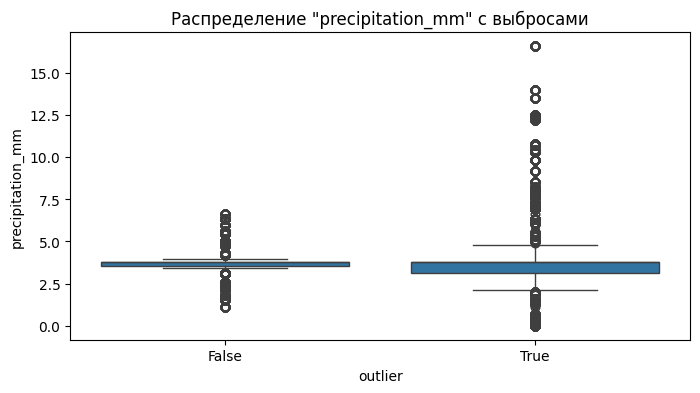

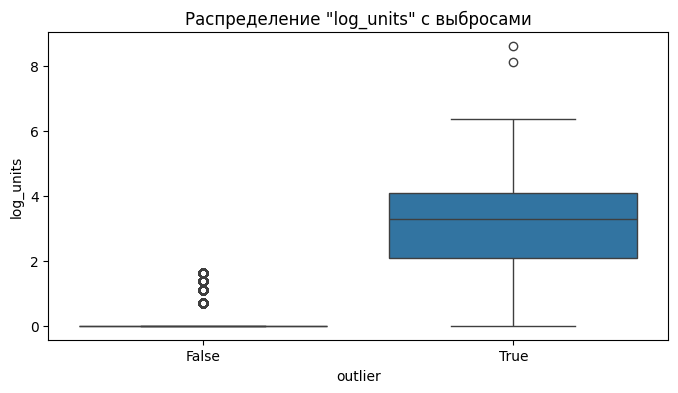

In [277]:
# === Сколько выбросов всего ===
total_rows = len(df)
total_outliers = df['outlier'].sum()
print(f"Общее количество выбросов: {total_outliers}")
print(f"Процент выбросов: {100 * total_outliers / total_rows:.2f}%")

# === Распределение по признакам ===
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['units', 'avg_temp_c', 'precipitation_mm', 'log_units']
outliers_df = df[df['outlier'] == True]

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='outlier', y=col)
    plt.title(f'Распределение "{col}" с выбросами')
    plt.show()



In [278]:
# === Примеры выбросов с наибольшими значениями units, температуры и осадков ===
print("\n🔍 ТОП 10 выбросов по units:")
print(outliers_df.sort_values('units', ascending=False)[['date', 'store_nbr', 'item_nbr', 'units', 'avg_temp_c', 'precipitation_mm']].head(10))

print("\n🔍 ТОП 10 по температуре:")
print(outliers_df.sort_values('avg_temp_c', ascending=False)[['date', 'store_nbr', 'item_nbr', 'units', 'avg_temp_c', 'precipitation_mm']].head(10))

print("\n🔍 ТОП 10 по осадкам:")
print(outliers_df.sort_values('precipitation_mm', ascending=False)[['date', 'store_nbr', 'item_nbr', 'units', 'avg_temp_c', 'precipitation_mm']].head(10))


🔍 ТОП 10 выбросов по units:
              date  store_nbr  item_nbr  units  avg_temp_c  precipitation_mm
709849  2012-11-15         37         5   5568   14.298702          3.781825
1429351 2013-11-21         37         5   3369   14.298702          3.781825
669021  2012-10-28         16        25    577   19.650000          3.430000
1461878 2013-12-08         17         9    503   15.680000          3.650000
483302  2012-08-05         33         9    476   14.298702          3.781825
543277  2012-09-01         33        44    469   14.298702          3.781825
1026092 2013-04-09         17         9    460   15.680000          3.650000
474457  2012-08-01         33        44    460   14.298702          3.781825
880717  2013-02-01         33        44    448   14.298702          3.781825
203617  2012-04-01         33        44    441   14.298702          3.781825

🔍 ТОП 10 по температуре:
            date  store_nbr  item_nbr  units  avg_temp_c  precipitation_mm
13972 2012-01-07       

Сначала мы отфильтровали экстремальные выбросы по продажам (более 1000 единиц в день), чтобы исключить влияние редких аномальных пиков. Далее выбросы, определённые через Z-оценку (>3), были заменены медианными значениями по каждому товару и магазину. Это позволило сохранить структуру данных и снизить искажения при обучении модели.

In [279]:
# Удалим экстремальные выбросы (например, > 1000 продаж в день)
#заменяем отклоняющиеся значения медианами по паре магазин + товар. Это сохраняет полноту выборки без искажения метрик.
df_cleaned = df[df['units'] <= 1000].copy()

#Заменим менее экстремальные выбросы (по Z-оценке) медианой по store + item
from scipy import stats

z_scores_units = np.abs(stats.zscore(df_cleaned['units']))
df_cleaned['units_z'] = z_scores_units

# Обнаружим оставшиеся выбросы по Z
unit_outliers_mask = df_cleaned['units_z'] > 3

# Рассчитаем медианы
median_map = df_cleaned.groupby(['store_nbr', 'item_nbr'])['units'].median()

# Заменим выбросы медианами
def replace_with_median(row):
    if row['units_z'] > 3:
        return median_map.get((row['store_nbr'], row['item_nbr']), row['units'])
    return row['units']

df_cleaned['units'] = df_cleaned.apply(replace_with_median, axis=1)
df_cleaned.drop(columns=['units_z'], inplace=True)

# Обновим log_units
df_cleaned['log_units'] = np.log1p(df_cleaned['units'])

# Сохраняем результат
df_cleaned.to_csv('train_no_extreme_outliers.csv', index=False)


Анализ мультиколлинеарности с помощью коэффициента VIF выявил сильную зависимость между температурой и осадками (VIF > 10). Это может негативно повлиять на стабильность коэффициентов в интерпретируемых моделях.

Кластеризация для выделения категорий

In [280]:
# === 1. Загрузка исходных данных
# Загрузка данных без выбросов
df = pd.read_csv('train_no_extreme_outliers.csv')
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)

# 1. Сортируем все уникальные недели и находим границу
all_weeks = sorted(weekly_sales['week'].unique())
split_idx = int(len(all_weeks) * 0.8)
train_weeks = all_weeks[:split_idx]
test_weeks  = all_weeks[split_idx:]

# 2. Делим датафрейм weekly_sales на train и test по неделе
weekly_train = weekly_sales[weekly_sales['week'].isin(train_weeks)]
weekly_test  = weekly_sales[weekly_sales['week'].isin(test_weeks)]

# 3. Строим pivot-таблицы с одинаковыми колонками (все train_weeks)
sales_train = weekly_train.pivot(index='item_nbr', columns='week', values='units').reindex(columns=train_weeks, fill_value=0)
sales_test  = weekly_test .pivot(index='item_nbr', columns='week', values='units').reindex(columns=train_weeks, fill_value=0)

# 4. Масштабирование и кластеризация только на train, затем predict для test
scaler = StandardScaler()
train_scaled = scaler.fit_transform(sales_train)
test_scaled  = scaler.transform(sales_test)

kmeans = KMeans(n_clusters=10, random_state=42)
train_labels = kmeans.fit_predict(train_scaled)
test_labels  = kmeans.predict(test_scaled)

# 5. Собираем Series item_nbr → category и мапим обратно в df
train_cat = pd.Series(train_labels, index=sales_train.index)
test_cat  = pd.Series(test_labels,  index=sales_test.index)
all_cat   = pd.concat([train_cat, test_cat])

df['category'] = df['item_nbr'].map(all_cat.to_dict())

# Построение интерпретируемой модели Lasso и корректировка прогноза на погоду


📊 VIF-анализ мультиколлинеарности:
            feature        VIF
0        avg_temp_c  12.739017
1  precipitation_mm  11.601494
2         city_code   4.143351


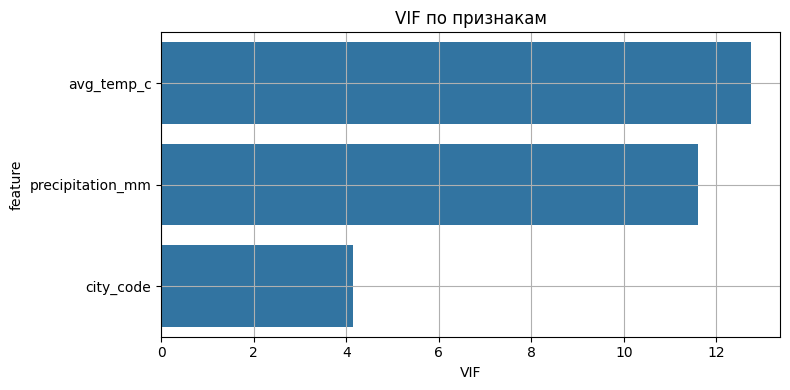


📌 Коэффициенты влияния погодных и географических признаков:
avg_temp_c          0.004736
precipitation_mm    0.006839
city_code           0.000163
category           -0.138987
dtype: float64


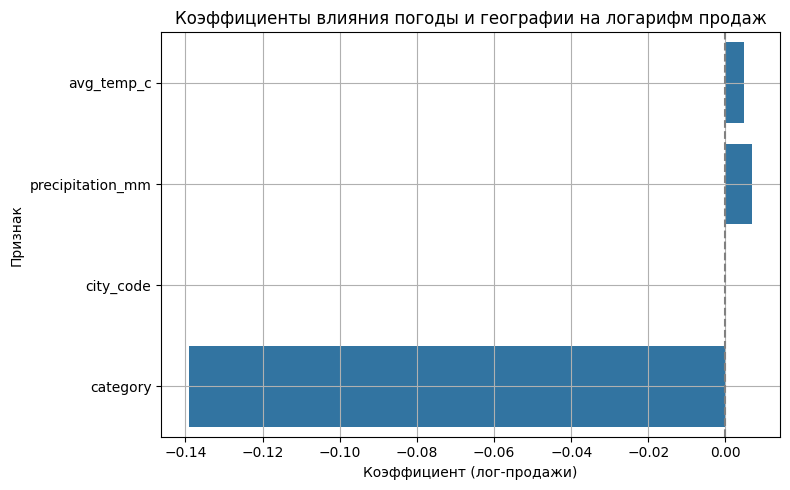


✅ Данные с учётом погодной коррекции сохранены в train_with_adjusted_forecast.csv


In [281]:
# === 2. VIF-анализ для оценки мультиколлинеарности
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

vif_df = df[['avg_temp_c', 'precipitation_mm', 'city_code']].dropna()
vif_data = pd.DataFrame()
vif_data["feature"] = vif_df.columns
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print("\n📊 VIF-анализ мультиколлинеарности:")
print(vif_data)

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(x="VIF", y="feature", data=vif_data)
plt.title("VIF по признакам")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. Регрессионная модель Lasso для интерпретируемости
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Загружаем датафрейм с категориями
df = pd.read_csv('train_clustered_categories.csv')
X = df[['avg_temp_c', 'precipitation_mm', 'city_code', 'category']]
y = df['log_units']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Lasso-регрессия с масштабированием
from sklearn.linear_model import LassoCV

model = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42))

model.fit(X_train, y_train)

# Получение и вывод коэффициентов
Lasso = model.named_steps['lassocv']
coefs = pd.Series(Lasso.coef_, index=X.columns)

print("\n📌 Коэффициенты влияния погодных и географических признаков:")
print(coefs)

# === Визуализация коэффициентов
plt.figure(figsize=(8, 5))
sns.barplot(x=coefs.values, y=coefs.index)
plt.axvline(0, color='gray', linestyle='--')
plt.title("Коэффициенты влияния погоды и географии на логарифм продаж")
plt.xlabel("Коэффициент (лог-продажи)")
plt.ylabel("Признак")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 4. Корректировка прогноза на основе погодных коэффициентов
df['adjusted_log_units'] = (
    df['log_units']
    + coefs['avg_temp_c'] * df['avg_temp_c']
    + coefs['precipitation_mm'] * df['precipitation_mm']
)
df['adjusted_units'] = df['adjusted_log_units'].apply(lambda x: max(0, round(np.expm1(x))))

# === 5. Сохранение результатов
coefs.to_csv('Lasso_weather_coefficients.csv')
df.to_csv('train_with_adjusted_forecast.csv', index=False)
print("\n✅ Данные с учётом погодной коррекции сохранены в train_with_adjusted_forecast.csv")


Мультиколлинеарность между температурой и осадками есть, но мы её контролируем через регуляризацию (Lasso) — это сохраняет интерпретируемость модели.
Температура и осадки действительно влияют на спрос, но слабо — важно учитывать их в сочетании с другими признаками.

Категория товара — ключевой фактор: товары с определённым паттерном продаж продаются существенно хуже/лучше.
Погодные факторы, такие как температура и осадки, имеют положительное, но слабое влияние.

Код города практически не влияет на результат, что может говорить о слабой его интерпретируемости в текущем виде.



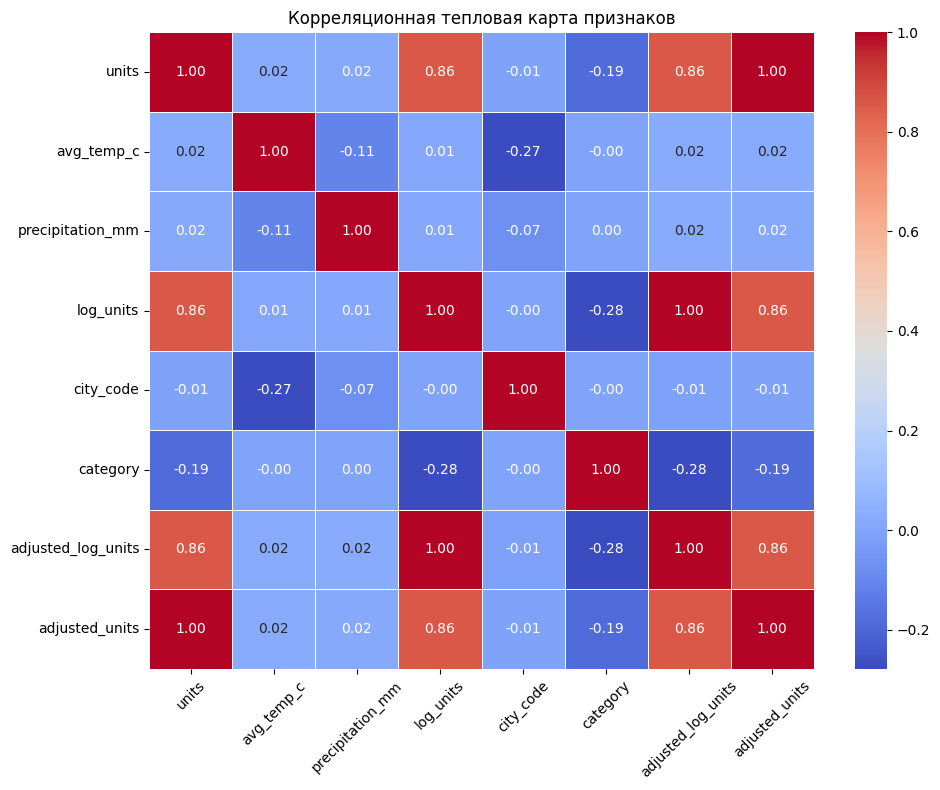

In [282]:

# Загрузка очищенных данных
df = pd.read_csv('train_with_adjusted_forecast.csv')
df['units'] = df['adjusted_units']

# Выбор только числовых признаков
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Удалим ID и категориальные коды, если они есть
exclude_cols = ['store_nbr', 'item_nbr', 'unique_id_code']
numeric_df = numeric_df.drop(columns=[col for col in exclude_cols if col in numeric_df.columns], errors='ignore')

# Расчет корреляционной матрицы
corr_matrix = numeric_df.corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Корреляционная тепловая карта признаков")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Погодные признаки (avg_temp_c, precipitation_mm) не коррелируют сильно между собой.

log_units сильно коррелирует с units.

Другие признаки (category, city_code) слабо коррелируют с остальными.


In [283]:
# Загрузка очищенного датасета (или подставь свой файл)
df = pd.read_csv('train_with_adjusted_forecast.csv')
df['units'] = df['adjusted_units']

# Выбираем только числовые признаки
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Удалим идентификаторы, если они есть (по желанию)
exclude_cols = ['store_nbr', 'item_nbr', 'unique_id_code']
numeric_df = numeric_df.drop(columns=[col for col in exclude_cols if col in numeric_df.columns], errors='ignore')

# Построение корреляционной матрицы
correlation_matrix = numeric_df.corr()

# Отображение матрицы
print("📊 Корреляционная матрица:")
print(correlation_matrix.round(2))

📊 Корреляционная матрица:
                    units  avg_temp_c  precipitation_mm  log_units  city_code  \
units                1.00        0.02              0.02       0.86      -0.01   
avg_temp_c           0.02        1.00             -0.11       0.01      -0.27   
precipitation_mm     0.02       -0.11              1.00       0.01      -0.07   
log_units            0.86        0.01              0.01       1.00      -0.00   
city_code           -0.01       -0.27             -0.07      -0.00       1.00   
category            -0.19       -0.00              0.00      -0.28      -0.00   
adjusted_log_units   0.86        0.02              0.02       1.00      -0.01   
adjusted_units       1.00        0.02              0.02       0.86      -0.01   

                    category  adjusted_log_units  adjusted_units  
units                  -0.19                0.86            1.00  
avg_temp_c             -0.00                0.02            0.02  
precipitation_mm        0.00               

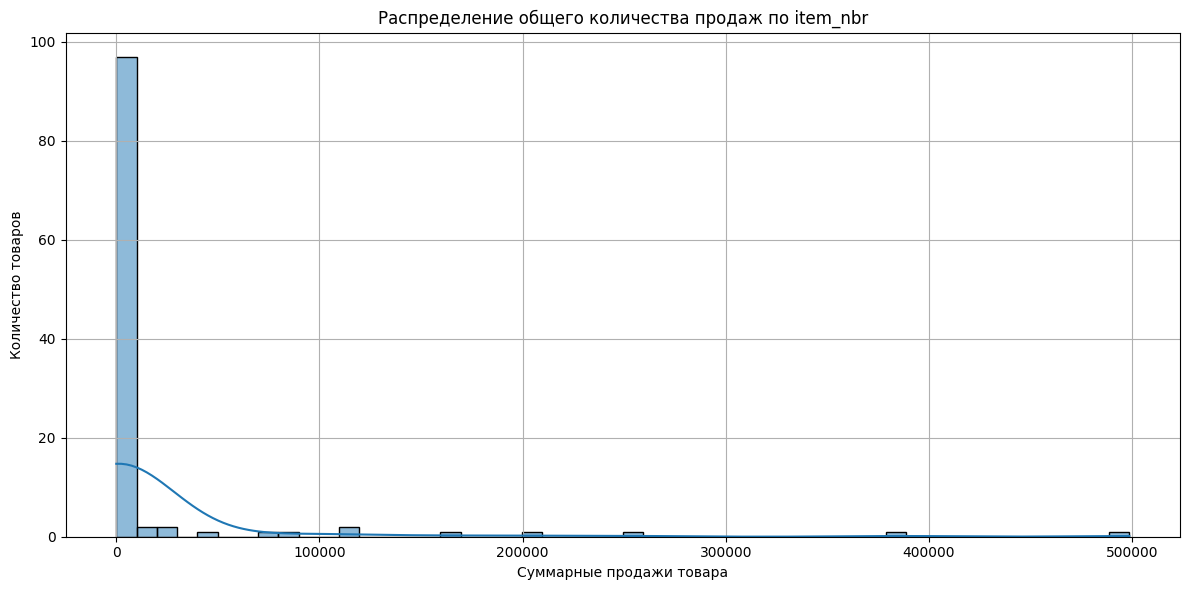

In [284]:
df = pd.read_csv('train_with_adjusted_forecast.csv')
df['units'] = df['adjusted_units']

# Агрегируем общее количество продаж по каждому товару
item_sales = df.groupby('item_nbr')['units'].sum().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.histplot(item_sales, bins=50, kde=True)
plt.title("Распределение общего количества продаж по item_nbr")
plt.xlabel("Суммарные продажи товара")
plt.ylabel("Количество товаров")
plt.grid(True)
plt.tight_layout()
plt.show()

 1. Пик около нуля
Большинство товаров (практически все) имеют низкие суммарные продажи

Это может означать:

товары с низким спросом

товары, появляющиеся/продающиеся только в отдельных магазинах или периодах

2. Немного товаров с ОЧЕНЬ высокими продажами
Некоторые единицы имеют продажи свыше 100,000 — 400,000+

Это "хиты продаж", которые:

популярны во многих магазинах

продаются постоянно

могут быть сезонными, но с массовым спросом



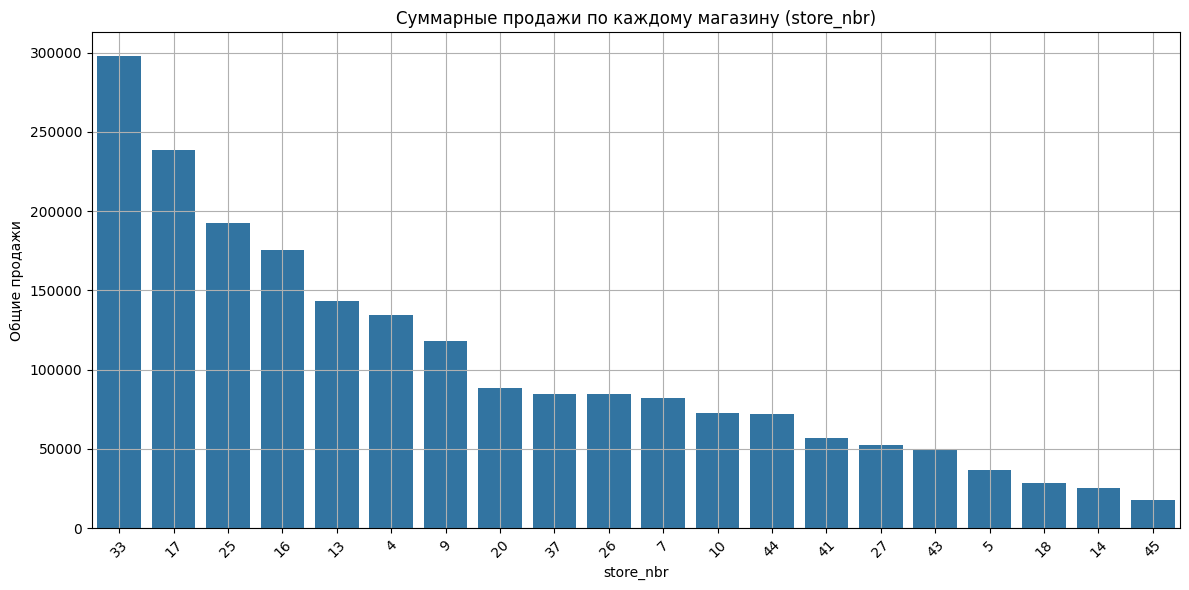

In [285]:
df = pd.read_csv('train_with_adjusted_forecast.csv')
df['units'] = df['adjusted_units']

# Агрегируем общее количество продаж по каждому магазину
store_sales = df.groupby('store_nbr')['units'].sum().sort_values(ascending=False)

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(x=store_sales.index.astype(str), y=store_sales.values)
plt.title("Суммарные продажи по каждому магазину (store_nbr)")
plt.xlabel("store_nbr")
plt.ylabel("Общие продажи")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [286]:
pivot = pd.pivot_table(
    df,
    values='units',
    index='store_nbr',
    columns='item_nbr',
    aggfunc='sum',
    fill_value=0
)

# Отображение части таблицы
print(pivot.head())

item_nbr   1    2    3    4      5    6    7    8       9    10   ...  102  \
store_nbr                                                         ...        
4            0    0    0    0      0    0    0    0  119643    0  ...    0   
5            0    0    0    0      0    0    0    0       0    0  ...    0   
7            0    0    0    0  54826    0  748    0       0    0  ...    0   
9            0    0    0    0  38914    0    0    0       0  831  ...    0   
10           0    0    0    0  55204    0    0    0       0    0  ...    0   

item_nbr   103  104  105  106  107  108  109  110  111  
store_nbr                                               
4            0    0    0    0    0    0    0    0    0  
5            0    0  104    0    0    0    0    0    0  
7            0    0    0    0    0    0    0    0    0  
9            0    0   79    0    0    0    0    0    0  
10           0    0    0    0    0    0    0    0    0  

[5 rows x 111 columns]


In [287]:
import holidays

# === 1. Загрузка данных ===
df = pd.read_csv('train_with_adjusted_forecast.csv')
df['units'] = df['adjusted_units']

# === 2. Приведение колонки 'date' к datetime ===
df['date'] = pd.to_datetime(df['date'])

# === 3. Год, месяц, день ===
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# === 4. Сезон по месяцу ===
df['season'] = 'unknown'
df.loc[df['month'].isin([12, 1, 2]), 'season'] = 'winter'
df.loc[df['month'].isin([3, 4, 5]), 'season'] = 'spring'
df.loc[df['month'].isin([6, 7, 8]), 'season'] = 'summer'
df.loc[df['month'].isin([9, 10, 11]), 'season'] = 'fall'

# === 5. Выходные (суббота и воскресенье) ===
df['weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

# === 6. Праздники США ===
us_holidays = holidays.US()
df['holidays'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)

# === 7. Проверка ===
print(df[['date', 'year', 'month', 'day', 'season', 'weekend', 'holidays']].head())

# === 8. Сохранение результата ===
df.to_csv('train_with_temporal_features.csv', index=False)

        date  year  month  day  season  weekend  holidays
0 2012-01-01  2012      1    1  winter        1         1
1 2012-01-01  2012      1    1  winter        1         1
2 2012-01-01  2012      1    1  winter        1         1
3 2012-01-01  2012      1    1  winter        1         1
4 2012-01-01  2012      1    1  winter        1         1


In [288]:
df = pd.read_csv('train_with_temporal_features.csv')
# === Определение сезона по месяцу ===
df['season'] = 'unknown'  # очищаем перед назначением
df.loc[df['month'].isin([6, 7, 8]), 'season'] = 'summer'
df.loc[df['month'].isin([9, 10, 11]), 'season'] = 'fall'
df.loc[df['month'].isin([12, 1, 2]), 'season'] = 'winter'
df.loc[df['month'].isin([3, 4, 5]), 'season'] = 'spring'

# === Признак праздников США ===
us_holidays = holidays.US()
df['holidays'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)

# === Подсчёт количества праздничных и обычных дней ===
print("Распределение по праздникам:")
print(df['holidays'].value_counts())

# === Сохраняем финальный результат ===
df.to_csv('train_final_temporal.csv', index=False)

Распределение по праздникам:
holidays
0    2002771
1      55833
Name: count, dtype: int64


In [289]:
df = pd.read_csv('train_final_temporal.csv')

# === Извлечение года, месяца и дня ===
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# === Признак выходного дня: 1 — выходной (Сб/Вс), 0 — будни ===
df['weekend'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# === Назначение сезона по месяцу ===
df['season'] = 'unknown'
df.loc[df['month'].isin([12, 1, 2]), 'season'] = 'winter'
df.loc[df['month'].isin([3, 4, 5]), 'season'] = 'spring'
df.loc[df['month'].isin([6, 7, 8]), 'season'] = 'summer'
df.loc[df['month'].isin([9, 10, 11]), 'season'] = 'fall'
# === Сохранение финального датафрейма ===
df.to_csv('train_enriched_temporal.csv', index=False)


In [290]:
df = pd.read_csv('train_enriched_temporal.csv')

# === One-hot кодирование признака 'season' ===
df_season = pd.get_dummies(df['season'], prefix='is')

# === Объединение с основным датафреймом ===
df = df.join(df_season)

# === Удаление оригинального признака 'season' ===
df.drop(columns=['season'], inplace=True)

# === Сохранение результата ===
df.to_csv('train_with_onehot_season.csv', index=False)

# === Проверка результата ===
print("Размерность после кодирования:", df.shape)
print(df.head())

Размерность после кодирования: (2058604, 25)
         date  store_nbr  item_nbr  units unique_id     city  avg_temp_c  \
0  2012-01-01          4         1      0       4_1  houston        10.2   
1  2012-01-01          4         2      0       4_2  houston        10.2   
2  2012-01-01          4         3      0       4_3  houston        10.2   
3  2012-01-01          4         4      0       4_4  houston        10.2   
4  2012-01-01          4         5      0       4_5  houston        10.2   

   precipitation_mm  log_units  city_code  ...  adjusted_units  year month  \
0               2.1        0.0          3  ...               0  2012     1   
1               2.1        0.0          3  ...               0  2012     1   
2               2.1        0.0          3  ...               0  2012     1   
3               2.1        0.0          3  ...               0  2012     1   
4               2.1        0.0          3  ...               0  2012     1   

   day  weekend  holidays  is

In [291]:
df = pd.read_csv('train_with_onehot_season.csv')

# ===Создание признака "sale": 1 если была продажа, иначе 0 ===
df['sale'] = np.where(df['units'] > 0, 1, 0)

# === Проверка распределения продаж ===
print("Распределение продаж (0 = нет, 1 = была):")
print(df['sale'].value_counts())

# ===  Сохранение результата ===
df.to_csv('train_final_with_sale.csv', index=False)

Распределение продаж (0 = нет, 1 = была):
sale
0    2006496
1      52108
Name: count, dtype: int64


In [292]:
df = pd.read_csv('train_final_with_sale.csv')
df['date'] = pd.to_datetime(df['date'])


# Кол-во дней с последней продажей этого товара в этом магазине
df = df.sort_values(['store_nbr', 'item_nbr', 'date'])

df['days_since_last_sale'] = df.groupby(['store_nbr', 'item_nbr'])['date'].diff().dt.days
df['days_since_last_sale'].fillna(999, inplace=True)  # если первая продажа — заполняем 999





#  Сохраняем обогащённый датафрейм
df.to_csv('train_sale_with_features.csv', index=False)

print("✅ Feature engineering completed. New shape:", df.shape)

<ipython-input-292-2521c238d6cd>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_since_last_sale'].fillna(999, inplace=True)  # если первая продажа — заполняем 999


✅ Feature engineering completed. New shape: (2058604, 27)


Обучение классификатора

<ipython-input-293-21cb19fcdf5b>:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_sale_with_features.csv')


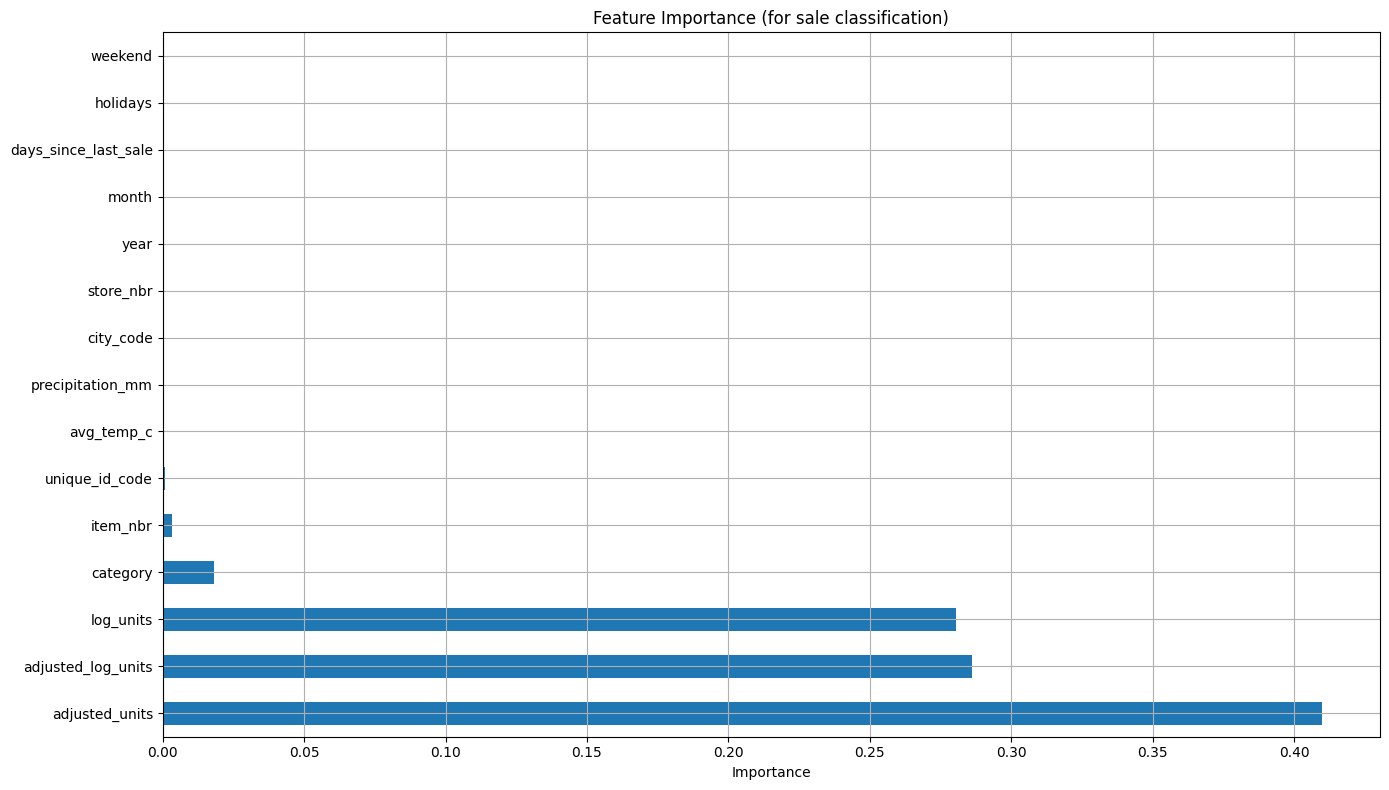

In [293]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# === 1. Загрузка данных ===
df = pd.read_csv('train_sale_with_features.csv')

# === 2. Разделение признаков и целевой переменной ===
X = df.drop(columns=['units', 'sale'])  # признаки
y_class = df['sale']                    # целевая переменная

# === 3. Удаление datetime-признаков (если остались) ===
for col in X.columns:
    if np.issubdtype(X[col].dtype, np.datetime64):
        print(f"Удалён datetime-признак: {col}")
        X = X.drop(columns=[col])

# === 4. Оставляем только числовые признаки ===
X = X.select_dtypes(include=['number'])

# === 5. Разделение на обучающую выборку для оценки важности признаков ===
X_train_full, _, y_train_full, _ = train_test_split(X, y_class, test_size=0.3, random_state=42)

# === 6. Обучение модели Random Forest ===
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train_full, y_train_full)

# === 7. Получение важности признаков ===
clf_feat_imp = pd.Series(clf_rf.feature_importances_, index=X_train_full.columns)

# === 8. Визуализация Top-15 признаков ===
plt.figure(figsize=(14, 8))
clf_feat_imp.nlargest(15).plot(kind='barh')
plt.title("Feature Importance (for sale classification)")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [295]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# === Загрузка данных ===
df = pd.read_csv('train_sale_with_features.csv')

df['date'] = pd.to_datetime(df['date'])
df['store_nbr'] = df['store_nbr'].astype(int)
df['item_nbr']  = df['item_nbr'].astype(int)

split_date = df['date'].quantile(0.8)
train_df = df[df['date'] <= split_date].copy()
test_df  = df[df['date'] >  split_date].copy()

# === Линейная модель Lasso для интерпретации погоды ===
train_df['avg_sales_last_7d']  = np.nan
train_df['avg_sales_last_30d'] = np.nan



for (store, item), grp in train_df.groupby(['store_nbr', 'item_nbr']):
    idx   = grp.index
    sales = grp['units']
    train_df.loc[idx, 'avg_sales_last_7d']  = sales.shift(1).rolling(7,  min_periods=1).mean().values
    train_df.loc[idx, 'avg_sales_last_30d'] = sales.shift(1).rolling(30, min_periods=1).mean().values

# === 5. Для теста подставляем последние значения из train (без утечки) ===
last7  = train_df.groupby(['store_nbr','item_nbr'])['avg_sales_last_7d'].last().to_dict()
last30 = train_df.groupby(['store_nbr','item_nbr'])['avg_sales_last_30d'].last().to_dict()

def fetch_last_feats(row):
    key = (row['store_nbr'], row['item_nbr'])
    return pd.Series({
        'avg_sales_last_7d':  last7.get(key, 0.0),
        'avg_sales_last_30d': last30.get(key, 0.0)
    })

test_feats = test_df.apply(fetch_last_feats, axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), test_feats.reset_index(drop=True)], axis=1)

# === 6. Подготовка данных и обучение модели Lasso (LogisticRegression с L1) ===
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'sale' in num_features:
    num_features.remove('sale')

X_train = train_df[num_features]
y_train = train_df['sale']
X_test  = test_df[num_features]
y_test  = test_df['sale']



<ipython-input-295-b5024207d017>:12: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_sale_with_features.csv')


# Классификация и регрессия с XGBoost и LGBM, подбор гиперпараметров



In [296]:
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

# Ресемплим вручную, чтобы посчитать scale_pos_weight
X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_res, y_res = rus.fit_resample(X_smote, y_smote)

counter = Counter(y_res)
scale_pos_weight = counter[0] / counter[1]
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight
    )),
])

# Сетка параметров для RandomizedSearch
param_dist = {
    'xgb__n_estimators': [100, 200, 300, 400],
    'xgb__max_depth': [3, 5, 7, 9],
    'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__min_child_weight': [1, 3, 5],
}

search = RandomizedSearchCV(
    pipe, param_distributions=param_dist,
    scoring='f1',
    n_iter=30,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)

# Предсказания на тесте (пробуем лучший pipeline)
best_pipe = search.best_estimator_
y_proba = best_pipe.predict_proba(X_test)[:, 1]




scale_pos_weight = 1.43
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [297]:
print("Лучшие параметры:", search.best_params_)
print(f"Лучший f1-score на кросс-валидации: {search.best_score_:.4f}")

# Предсказания на тесте (пробуем лучший pipeline)
best_pipe = search.best_estimator_
y_proba = best_pipe.predict_proba(X_test)[:, 1]

Лучшие параметры: {'xgb__subsample': 0.8, 'xgb__n_estimators': 400, 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.6}
Лучший f1-score на кросс-валидации: 0.2265


In [298]:
# Подбор оптимального порога для F1
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Оптимальный порог: {best_threshold:.2f}, F1-score на тесте: {f1_scores[best_idx]:.4f}")

# Финальный предсказания с оптимальным порогом
y_pred_final = (y_proba >= best_threshold).astype(int)

print(f"ROC-AUC на тесте: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

Оптимальный порог: 0.30, F1-score на тесте: 0.5294
ROC-AUC на тесте: 0.8708

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99    401837
           1       0.47      0.61      0.53      9307

    accuracy                           0.98    411144
   macro avg       0.73      0.80      0.76    411144
weighted avg       0.98      0.98      0.98    411144



Такие результаты связаны с сильным дисбалансом классов (поэтому применялись различные способы с борьбой с дсибалансом)

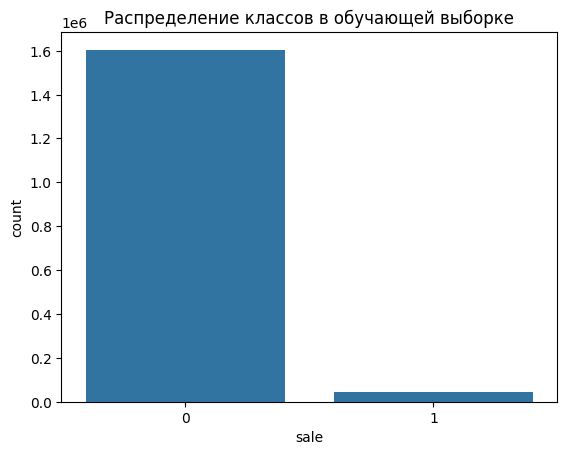

In [299]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.title("Распределение классов в обучающей выборке")
plt.show()


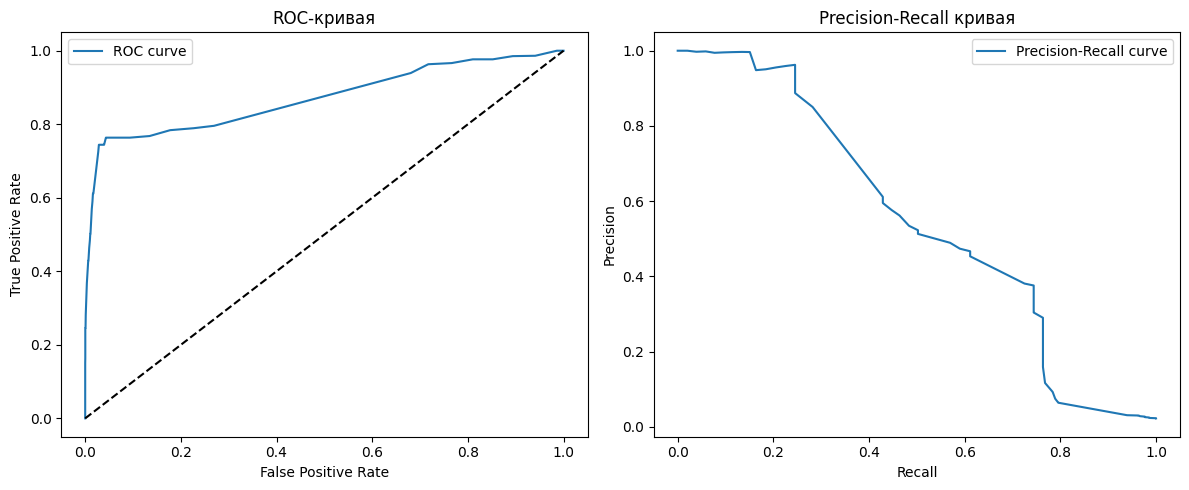

In [300]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# ROC и PR кривые
fpr, tpr, _ = roc_curve(y_test, y_scores)
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall кривая')
plt.legend()

plt.tight_layout()
plt.show()



Для такого сильно дисбаланса вышла хорошая модель:

Модель выдаёт каждому объекту «вероятность» класса 1.
По умолчанию обычно берут порог 0.5: все объекты с p(1) ≥ 0.5 относят к классу 1.

Здесь же был подобран порог 0.30, при котором достигается наилучший F1-score на  тесте.

Падание порога с 0.5 до 0.3 приводит к тому, что модель чаще предсказывает «1», что увеличивает recall (больше «1» вообще отловили), но может пожертвовать precision (в потоке «1» подмешивается больше ошибок).

Высокий ROC-AUC говорит о потенциальной способности,.

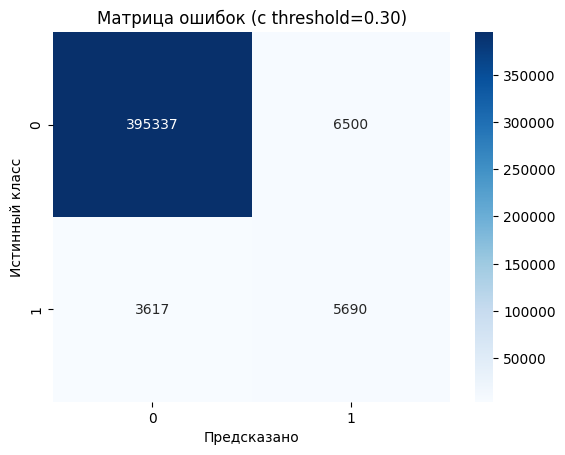

In [301]:
from sklearn.metrics import confusion_matrix

# Матрица ошибок с учётом подобранного порога
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Предсказано')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок (c threshold={:.2f})'.format(best_threshold))
plt.show()

In [302]:
# Получаем обученный XGBClassifier из pipeline
xgb_model = best_pipe.named_steps['xgb']

# Получаем важности признаков
importances = xgb_model.feature_importances_

# Можно отобразить в таблице
import pandas as pd

feature_names = X_train.columns  # если у тебя DataFrame
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

print(feat_imp_df)


            feature  importance
3          category    0.795171
2         city_code    0.096722
1  precipitation_mm    0.056604
0        avg_temp_c    0.051503


<ipython-input-303-3dca4d0f2e71>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')


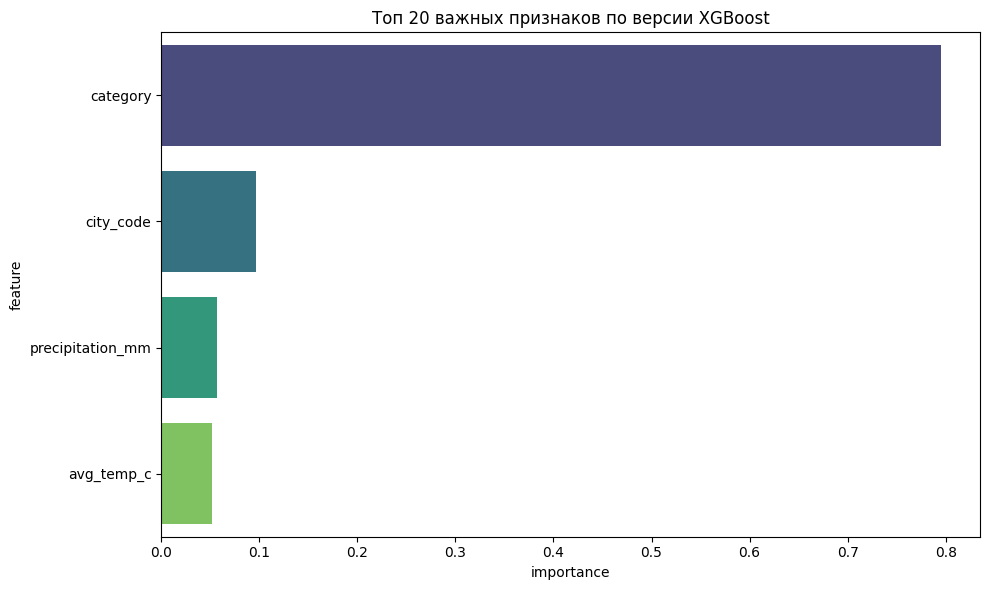

In [303]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='viridis')
plt.title('Топ 20 важных признаков по версии XGBoost')
plt.tight_layout()
plt.show()


Обучение регрессора

In [304]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# === 1. Загрузка данных ===
df = pd.read_csv('train_sale_with_features.csv')

# === 2. Разделение признаков ===
# Выделяем целевую переменную для классификации (продажа или нет) и регрессии (units)
y_class = df['sale']
y_units = df['units']

# Автоматически определяем числовые и категориальные признаки
num_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(['sale', 'units']).tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# === 3. Train/Test split ===
X_train, X_test, y_class_train, y_class_test, y_units_train_full, y_units_test_full = \
    train_test_split(
        df[num_features + cat_features], y_class, y_units,
        test_size=0.3, random_state=42, stratify=y_class
    )

# === 4. Pipeline для классификации ===
preprocessor_clf = ColumnTransformer([  # предобработка для классификации
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])
clf_pipeline = Pipeline([
    ('preproc', preprocessor_clf),
    ('clf', LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42))
])
clf_pipeline.fit(X_train, y_class_train)

# Предсказания вероятности продажи и бинарного исхода
y_class_pred_proba = clf_pipeline.predict_proba(X_test)[:, 1]
# Выбираем порог по ROC AUC (по умолчанию 0.5)
y_class_pred = (y_class_pred_proba > 0.5).astype(int)

# === 5. Подготовка данных для регрессии ===
# Фильтруем по предсказанным продажам\mask_train = clf_pipeline.predict(X_train) == 1
mask_train = clf_pipeline.predict(X_train) == 1
mask_test  = y_class_pred == 1

X_train_reg = X_train.loc[mask_train]
X_test_reg  = X_test.loc[mask_test]
y_train_reg = y_units_train_full.loc[mask_train]
y_test_reg  = y_units_test_full.loc[mask_test]

# === 6. Pipeline для регрессии ===
preprocessor_reg = ColumnTransformer([  # предобработка для регрессии
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])
reg_pipeline = Pipeline([
    ('preproc', preprocessor_reg),
    ('reg', LGBMRegressor(random_state=42))
])

# Параметры для RandomizedSearch
param_dist = {
    'reg__learning_rate': [0.01, 0.05, 0.1],
    'reg__n_estimators': [100, 300, 500, 1000],
    'reg__num_leaves': [31, 63, 127],
    'reg__max_depth': [-1, 10, 20],
    'reg__subsample': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    reg_pipeline, param_dist, n_iter=20, cv=3, scoring='neg_root_mean_squared_error',
    n_jobs=-1, random_state=42
)
search.fit(X_train_reg, y_train_reg)

# Лучший регрессионный прогноз
y_pred_base = search.predict(X_test_reg)
rmse_base = np.sqrt(mean_squared_error(y_test_reg, y_pred_base))

# === 7. Корректировка прогноза по погоде ===
# Можно сразу включить weather-признаки в модель, но если нужна пост-коррекция:
coeffs = {'avg_temp_c': coefficients['avg_temp_c'],
          'precipitation_mm': coefficients['precipitation_mm']}
# вычисляем средние на трейне
temp_mean = df.loc[X_train_reg.index, 'avg_temp_c'].mean()
precip_mean = df.loc[X_train_reg.index, 'precipitation_mm'].mean()
# дельты на тесте
delta_temp   = df.loc[X_test_reg.index, 'avg_temp_c'] - temp_mean
ndelta_precip = df.loc[X_test_reg.index, 'precipitation_mm'] - precip_mean
adjustment_factor = np.exp(
    coeffs['avg_temp_c'] * delta_temp + coeffs['precipitation_mm'] * ndelta_precip
)

y_pred_adj = y_pred_base * adjustment_factor
rmse_adj = np.sqrt(mean_squared_error(y_test_reg, y_pred_adj))


<ipython-input-304-dfdb0766abca>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_sale_with_features.csv')
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3324
[LightGBM] [Info] Number of data points in the train set: 36476, number of used features: 1277
[LightGBM] [Info] Start training from score 39.340416


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [305]:
# Вывод результатов ===
results = pd.DataFrame([{
    'Model': 'LGBM_REG',
    'RMSE Base': round(rmse_base, 14),
    'RMSE Adjusted (weather)': round(rmse_adj, 14)
}])
print(results)

      Model  RMSE Base  RMSE Adjusted (weather)
0  LGBM_REG   0.104398                 0.104398


Как можно увидеть модель хороша и покавыает небольшую ошибку и без добавленных признаков

In [313]:
print('Относосительная ошибка =', rmse_base/y_test_reg.mean()* 100, '%')

Относосительная ошибка = 0.2642803270067814 %


# Визуализации и гео-аналитика (HeatMap)

In [306]:
# Группируем продажи по складу и городу
train = pd.read_csv("/content/train.csv")
coords = pd.read_csv("/content/store_city_coordinates.csv")

# Добавим город к каждому store_nbr
train = train.merge(coords[['store_nbr', 'city', 'latitude', 'longitude']], on='store_nbr', how='left')

# Добавим продажи по складу и городу
sales_by_store_city = (
    train.groupby(['store_nbr', 'city', 'latitude', 'longitude'])['units']
    .sum()
    .reset_index()
    .rename(columns={'units': 'total_units'})
)

sales_by_store_city.to_csv("/content/sales_region_map.csv", index=False)


In [307]:
sales_by_store_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   store_nbr    20 non-null     int64  
 1   city         20 non-null     object 
 2   latitude     20 non-null     float64
 3   longitude    20 non-null     float64
 4   total_units  20 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 932.0+ bytes


In [308]:
import folium
from folium.plugins import HeatMap


# Центрируем карту по средним координатам
map_center = [sales_by_store_city['latitude'].mean(), sales_by_store_city['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=2)

# Формируем данные для тепловой карты: [lat, lon, вес]
heat_data = sales_by_store_city[['latitude', 'longitude', 'total_units']].values.tolist()

# Добавляем слой HeatMap
HeatMap(heat_data).add_to(m)

# Сохраняем в HTML
map_file = '/content/store_heatmap.html'
m.save(map_file)

# Показать карту в ноутбуке
m
